In [5]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size,sequence_length,input_dim))

In [7]:
x.size()

torch.Size([1, 4, 512])

<img src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" alt="Description of the image" width="400"/>


In [8]:
qkv_layer = nn.Linear(input_dim,3*d_model)

In [9]:
qkv = qkv_layer(x)

In [10]:
qkv.shape

torch.Size([1, 4, 1536])

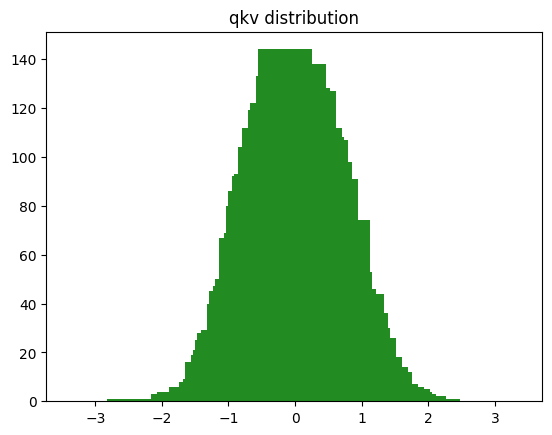

In [11]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv,bins=200,min=-3,max=3)
x_val = np.arange(-1,1,0.01) * 3
plt.bar(x_val,y_val,align='center',color=['forestgreen'])
plt.title('qkv distribution');

In [12]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size,sequence_length,num_heads,3*head_dim)

In [13]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [14]:
qkv = qkv.permute(0,2,1,3) # [batch_size,num_heads,sequence_length,3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [15]:
q, k, v = qkv.chunk(3,dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for multiple heads

$$ \text{self attention} = \text{softmax}\bigg(\frac{Q \cdot K^T}{\sqrt{d_k}} + M\bigg) $$


$$ \text{new V} = \text{self attention} \cdot V $$


In [16]:
q.size(),k.transpose(-2,-1).size()

(torch.Size([1, 8, 4, 64]), torch.Size([1, 8, 64, 4]))

In [17]:
#4,64 64,4

In [18]:
d_k = q.size()[-1]
scaled = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [19]:
k.T.shape

<ipython-input-19-879c2705464e>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [20]:
y = torch.randn(2,3)
torch.transpose(y,0,1)

tensor([[-0.1817, -0.2143],
        [-1.6709,  0.2364],
        [ 0.2350, -1.1124]])

In [21]:
torch.transpose(y,1,0)

tensor([[-0.1817, -0.2143],
        [-1.6709,  0.2364],
        [ 0.2350, -1.1124]])

In [22]:
torch.all(k.transpose(-1, -2) == k.transpose(-2, -1))

tensor(True)

In [23]:
k.transpose(-1,-2).shape

torch.Size([1, 8, 64, 4])

In [24]:
mask = torch.full(scaled.size(),float('-inf'))
mask = torch.triu(mask,diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [25]:
(scaled+mask)

tensor([[[[-0.0868,    -inf,    -inf,    -inf],
          [-0.0809, -0.1379,    -inf,    -inf],
          [-0.0877,  0.0073, -0.0232,    -inf],
          [ 0.8311,  0.0758, -0.3298, -0.1760]],

         [[-0.4395,    -inf,    -inf,    -inf],
          [-0.3159, -0.2289,    -inf,    -inf],
          [-0.0331,  0.2336,  0.4846,    -inf],
          [ 0.3386,  0.0266, -0.2299,  0.2511]],

         [[-0.0304,    -inf,    -inf,    -inf],
          [-0.0036, -0.1700,    -inf,    -inf],
          [ 0.2380,  0.0655,  0.2677,    -inf],
          [ 0.0827, -0.4907, -0.0117,  0.2669]],

         [[-0.2559,    -inf,    -inf,    -inf],
          [-0.2146,  0.0042,    -inf,    -inf],
          [ 0.6631, -0.3793, -0.2450,    -inf],
          [ 0.4865,  0.0244, -0.0579,  0.0580]],

         [[-0.1099,    -inf,    -inf,    -inf],
          [-0.5228, -0.0950,    -inf,    -inf],
          [-0.5310, -0.0476, -0.5859,    -inf],
          [-0.3061,  0.3599,  0.6858, -0.2863]],

         [[ 0.5561,    -inf,  

In [26]:
scaled+=mask

In [27]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))


0.6269606805367254

In [28]:
attention = F.softmax(scaled, dim=-1)


In [29]:
attention.shape

torch.Size([1, 8, 4, 4])

In [30]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5142, 0.4858, 0.0000, 0.0000],
        [0.3158, 0.3473, 0.3369, 0.0000],
        [0.4655, 0.2187, 0.1458, 0.1700]], grad_fn=<SelectBackward0>)

In [31]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [32]:
import math

In [35]:
def scaled_dot_product(q,k,v,mask=None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q,k.transpose(-1,-2)) / math.sqrt(d_k)
  if mask is not None:
    scaled+=mask
  attention = F.softmax(scaled,dim=-1)
  values = torch.matmul(attention,v)
  return values, attention

In [36]:
values, attention = scaled_dot_product(q,k,v,mask=mask)

In [37]:
attention.shape

torch.Size([1, 8, 4, 4])

In [38]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5142, 0.4858, 0.0000, 0.0000],
        [0.3158, 0.3473, 0.3369, 0.0000],
        [0.4655, 0.2187, 0.1458, 0.1700]], grad_fn=<SelectBackward0>)

In [39]:
values = values.reshape(batch_size,sequence_length,num_heads*head_dim)

In [40]:
linear_layer = nn.Linear(d_model,d_model)

In [41]:
out = linear_layer(values)

In [42]:
out.shape

torch.Size([1, 4, 512])

In [43]:
out

tensor([[[-0.1713, -0.7182, -0.1262,  ..., -0.5365,  0.4675, -0.0844],
         [-0.0340, -0.1854,  0.1081,  ...,  0.0616, -0.0261, -0.2309],
         [ 0.2515, -0.4457,  0.3090,  ..., -0.3428,  0.1374,  0.3158],
         [ 0.1158, -0.0686,  0.4879,  ...,  0.0269,  0.4248,  0.1391]]],
       grad_fn=<ViewBackward0>)

In [48]:
class MultiHeadAttention(nn.Module):
  def __init__(self,input_dim,d_model,num_heads):
    super().__init__()
    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(input_dim, 3* d_model)
    self.linear_layer = nn.Linear(d_model,d_model)

  def forward(self,x,mask=None):
    batch_size, sequence_length, input_dim = x.size()
    print(f'x.size(): {x.size()}')
    qkv = self.qkv_layer(x)
    print(f"qkv.size(): {qkv.size()}")
    qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
    print(f"qkv.size(): {qkv.size()}")
    qkv = qkv.permute(0, 2, 1, 3)
    print(f"qkv.size(): {qkv.size()}")
    q, k, v = qkv.chunk(3, dim=-1)
    print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
    values, attention = scaled_dot_product(q, k, v, mask)
    print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
    values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
    print(f"values.size(): {values.size()}")
    out = self.linear_layer(values)
    print(f"out.size(): {out.size()}")
    return out


In [49]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
